# MBESv2 generation
# Finalized rerun of NG library

- Need to filter:
    - polyT sequences
    - restriction site sequences
    - duplicate guides (noting + saving alternatives)
        - Don't filter if it's ABE vs. CBE
        - I'm going to save the information about which variant is targeted by potentially the protospacer. Then, in the analysis pipeline, I can have crispresso align to BOTH expected amplicons by sorting it into 2 different folder, to see if the alternative mutation is being effectively created.
    - Add hamming barcodes
    - and subpooled
    - Add non-targetting controls + safe-targetting controls
    - Change guide ID #'s to actually make sense

In [ ]:
from pegg import base
from pegg import prime
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
#loading in reference genome GRCm39 (mouse)
filepath = '/Users/samgould/Desktop/FSR Lab/reference files/GRCm39 (mouse)/GCF_000001635.27_GRCm39_genomic.fna.gz'
chrom_dict, i = prime.genome_loader(filepath)

In [ ]:
input = pd.read_csv('source_data/msk_BE_pts_over_2_v2.csv')

#editing columns to make them amenable to PEGG
input['Start_Position'] = [int(i) for i in input['start_m']] #had to change these coordinates to integers
input['End_Position'] = [int(i) for i in input['end_m']]
input['Variant_Type'] = input['type_m']
input['Reference_Allele'] = input['ref_seq_m']
input['Tumor_Seq_Allele2'] = input['alt_seq_m']
input['Chromosome'] = [i[3:] for i in input['chr_m']] #getting rid of "chr_"
input

,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,end_h,ref_seq_h,...,alt_seq_m,HGVSc_m,HGVSp_m,index,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Chromosome
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133730186,133730186,A,...,G,ENSMUST00000075759.13:c.29A>G,NaN,0,31668930,31668930,SNP,A,G,2
1,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133738349,133738349,G,...,A,ENSMUST00000075759.13:c.805G>A,G269E,1,31674718,31674718,SNP,G,A,2
2,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133748403,133748403,A,...,G,ENSMUST00000075759.13:c.1120A>G,E374G,2,31680830,31680830,SNP,A,G,2
3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760819,133760819,G,...,A,ENSMUST00000075759.13:c.3177G>A,E1060K,3,31691660,31691660,SNP,G,A,2
4,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133759553,133759553,G,...,A,ENSMUST00000075759.13:c.1932G>A,G645S,4,31690415,31690415,SNP,G,A,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72992964,72992964,C,...,A,ENSMUST00000220518.2:c.1080G>A,G361R,11125,109519960,109519960,SNP,G,A,8
10944,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993335,72993335,C,...,A,ENSMUST00000220518.2:c.709G>A,R237Q,11126,109519589,109519589,SNP,G,A,8
10945,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72845844,72845844,G,...,T,ENSMUST00000220518.2:c.3652C>T,S1218L,11127,109660257,109660257,SNP,C,T,8
10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993336,72993336,G,...,T,ENSMUST00000220518.2:c.708C>T,R237delins*,11128,109519588,109519588,SNP,C,T,8


In [99]:
gRNA_NG = base.run_base(input, 
                    input_format='cBioPortal', 
                    chrom_dict=chrom_dict,
                    PAM='NG',
                    filtration = 'ABE+CBE',
                    ideal_edit_window=[4,8],
                    proto_size = 19,
                    before_proto_context=10,
                    sensor_length=42, 
                    RE_sites=["CGTCTC", "GAATTC"]
                    ) 


In [106]:
#filtration of raw results
gRNA_ideal = gRNA_NG[gRNA_NG['Ideal_Edit_Window']==True] #filter out non ideal edit window
#filter out polyT containing guides/sensors
gRNA_ideal = gRNA_ideal[gRNA_ideal['contains_polyT_terminator']==False]
#filter out Esp3I and EcoRI containing guides/sensors
gRNA_ideal = gRNA_ideal[gRNA_ideal['contains_RE_site']==False]
gRNA_ideal = gRNA_ideal.reset_index().drop(columns = ['index', 'level_0'])
gRNA_ideal



,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,end_h,...,Ideal_Edit_Window,Editor,gRNA_id,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site
0,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133730186,133730186,...,True,ABE,gRNA_0,65.0,TAACCCAAGACCCGGAGCTTTTCACCTTAGAAAAAAAAAAAA,TAACCCAAGACCCGGAGCTTTTCACCTCAGAAAAAAAAAAAA,reverse-complement,No Error,False,False
1,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133730186,133730186,...,True,ABE,gRNA_1,49.0,AACCCAAGACCCGGAGCTTTTCACCTTAGAAAAAAAAAAAAA,AACCCAAGACCCGGAGCTTTTCACCTCAGAAAAAAAAAAAAA,reverse-complement,No Error,False,False
2,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133730186,133730186,...,True,ABE,gRNA_2,42.0,ACCCAAGACCCGGAGCTTTTCACCTTAGAAAAAAAAAAAAAA,ACCCAAGACCCGGAGCTTTTCACCTCAGAAAAAAAAAAAAAA,reverse-complement,No Error,False,False
3,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760819,133760819,...,True,CBE,gRNA_20,53.0,TGTGCCTTGCCATCTCCCGGAACTCAGAGCAGATGGCCAGCC,TGTGCCTTGCCATCTCCCGGAACTCAAAGCAGATGGCCAGCC,reverse-complement,No Error,False,False
4,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760819,133760819,...,True,CBE,gRNA_21,39.0,CTGTGCCTTGCCATCTCCCGGAACTCAGAGCAGATGGCCAGC,CTGTGCCTTGCCATCTCCCGGAACTCAAAGCAGATGGCCAGC,reverse-complement,No Error,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13507,10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993336,72993336,...,True,CBE,gRNA_57131,72.0,TCAGGTAATCCTTGTTGCTTTTGTGTCGCACGTCAAAAACGC,TCAGGTAATCCTTGTTGCTTTTGTGTCACACGTCAAAAACGC,reverse-complement,No Error,False,False
13508,10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993336,72993336,...,True,CBE,gRNA_57133,62.0,TTCAGGTAATCCTTGTTGCTTTTGTGTCGCACGTCAAAAACG,TTCAGGTAATCCTTGTTGCTTTTGTGTCACACGTCAAAAACG,reverse-complement,No Error,False,False
13509,10947,ZNRF3,ENSG00000183579.11,ENST00000544604.2,chr22,9,+,True,29439321,29439321,...,True,CBE,gRNA_57140,60.0,CATCTGCACCCTTCACATACACCACTGGCCTCTTAAGAGGGT,CATCTGCACCCTTCACATACACCACTAGCCTCTTAAGAGGGT,reverse-complement,No Error,False,False
13510,10947,ZNRF3,ENSG00000183579.11,ENST00000544604.2,chr22,9,+,True,29439321,29439321,...,True,CBE,gRNA_57141,65.0,GCATCTGCACCCTTCACATACACCACTGGCCTCTTAAGAGGG,GCATCTGCACCCTTCACATACACCACTAGCCTCTTAAGAGGG,reverse-complement,No Error,False,False


In [116]:
#pruning duplicate guides for nearby variants
#doing it on a per editor basis (don't want to filter repeated guides if one is ABE and the other is CBE)

abe = gRNA_ideal[gRNA_ideal['Editor']=='ABE']

cbe = gRNA_ideal[gRNA_ideal['Editor']=='CBE']

print(len(np.unique(abe['Protospacer'])))
print(len(abe))
print(len(np.unique(cbe['Protospacer'])))
print(len(cbe))

1034
1056
12225
12456


In [139]:
#gRNA_ideal.to_csv('MBESv2_DUPLICATES_INCLUDED.csv', index=False)

In [134]:
def duplicate_finder(abe):
    
    num_potential_vars = []
    duplicate_mutation_idx = []
    for i, val in abe.iterrows():

        p = val['Protospacer']
        subset = abe[abe['Protospacer']==p]
        if len(subset)==1:
            num_potential_vars.append(1)
            duplicate_mutation_idx.append(None)
        elif len(subset)>1:
            num_potential_vars.append(len(subset))
            duplicate_mutation_idx.append(list(subset['mutation_idx']))


    abe['num_potential_vars'] = num_potential_vars
    abe['potential_mutation_idx'] = duplicate_mutation_idx

    abe_no_dups = abe.drop_duplicates(subset='Protospacer', keep='first')

    assert len(np.unique(abe_no_dups['Protospacer'])) == len(abe_no_dups), 'Still duplicate protos'

    return abe_no_dups

In [135]:
abe_no_dups = duplicate_finder(abe)
cbe_no_dups = duplicate_finder(cbe)

In [150]:
comb_no_dups = pd.concat((abe_no_dups, cbe_no_dups)).sort_values(by='mutation_idx')
#and rename the gRNA_id
comb_no_dups['gRNA_id'] = [f'gRNA_{i}' for i in range(1, len(comb_no_dups)+1)]
comb_no_dups.to_csv('MBESv2_no_duplicates_targeting_guides_only.csv', index=False)

# Non-targeting and safe-targeting controls

In [156]:
from pegg import library

In [159]:
#loading in reference genome GRCm39 (mouse)
filepath2 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCm38.p6 (mouse)/ncbi-genomes-2022-04-04/GCF_000001635.26_GRCm38.p6_genomic.fna.gz'
chrom_dict_38, i = prime.genome_loader(filepath2)

In [162]:
#only works with GrCm38
possible_safe = library.safe_muts(10000, chrom_dict_38, organism='mouse')

#filter for position 6
# 2.5% safe targeting for ABE and CBE
# 1% 

In [166]:
change_dict = {'C':'T','T':'C', 'A':'G', 'G':'A'}

possible_safe['Tumor_Seq_Allele2'] = [change_dict[i] for i in possible_safe['Tumor_Seq_Allele2']]

In [168]:
#and then generating guides for filtration

safe_NG = base.run_base(possible_safe, 
                    input_format='cBioPortal', 
                    chrom_dict=chrom_dict_38,
                    PAM='NG',
                    filtration = 'ABE+CBE',
                    ideal_edit_window=[4,8],
                    proto_size = 19,
                    before_proto_context=10,
                    sensor_length=42, 
                    RE_sites=["CGTCTC", "GAATTC"]
                    ) 

In [192]:
#and then filtration
safe_NG_filt = safe_NG[(safe_NG['contains_polyT_terminator']==False) & (safe_NG['contains_RE_site']==False)]
safe_NG_filt_pos6 = safe_NG_filt[safe_NG_filt['Protospacer_Location']==6] #following Ondine's convention, selecting guides that target base at position +6 (center of window)

cbe_safe = safe_NG_filt_pos6[safe_NG_filt_pos6['Editor']=='CBE'].reset_index().drop(columns='index')
abe_safe = safe_NG_filt_pos6[safe_NG_filt_pos6['Editor']=='ABE'].reset_index().drop(columns='index')

abe_safe

,mutation_idx,Chromosome,Variant_Type,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,classification,seq_start,seq_end,...,Ideal_Edit_Window,Editor,gRNA_id,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site
0,8,1,SNP,3641601,3641601,T,C,safe-targeting control,3641481,3641721,...,True,ABE,gRNA_26,48.0,TTTCAAAGCGCTTCAGACAAAGGATATCAACCTACTGCACTA,TTTCAAAGCGCTTCAGACAAAGGATACCAACCTACTGCACTA,reverse-complement,No Error,False,False
1,42,1,SNP,9196067,9196067,T,C,safe-targeting control,9195947,9196187,...,True,ABE,gRNA_128,54.0,TGCCAATTTACATACCCATGCACTTCTGACACAAAGAAAAGT,TGCCAATTTACATACCCATGCACTTCCGACACAAAGAAAAGT,reverse-complement,No Error,False,False
2,62,1,SNP,13821782,13821782,A,G,safe-targeting control,13821662,13821902,...,True,ABE,gRNA_195,55.0,ATTATGTTTTCTGGAGGACCTCTGTATCTTGCAAGATATCGG,ATTATGTTTTCTGGAGGACCTCTGTACCTTGCAAGATATCGG,reverse-complement,No Error,False,False
3,98,1,SNP,18186971,18186971,A,G,safe-targeting control,18186851,18187091,...,True,ABE,gRNA_327,47.0,TATCTAGATTCAGCATGAGTGGGAGGTTTCTATCTTAATATA,TATCTAGATTCAGCATGAGTGGGAGGCTTCTATCTTAATATA,reverse-complement,No Error,False,False
4,128,1,SNP,23570327,23570327,T,C,safe-targeting control,23570207,23570447,...,True,ABE,gRNA_417,36.0,ATTAATAAAACTAAGAATATTCAATGTCATGTAAATATGTAC,ATTAATAAAACTAAGAATATTCAATGCCATGTAAATATGTAC,reverse-complement,No Error,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,9976,Y,SNP,16490559,16490559,A,G,safe-targeting control,16490439,16490679,...,True,ABE,gRNA_32011,40.0,TGTTCATTTACTTACAACACCAGTGCTTAGGATTTTGGGAGG,TGTTCATTTACTTACAACACCAGTGCCTAGGATTTTGGGAGG,reverse-complement,No Error,False,False
935,9981,Y,SNP,32426010,32426010,A,G,safe-targeting control,32425890,32426130,...,True,ABE,gRNA_32021,27.0,AGTCCTATTTCAGAAGGATCAACAATTAACCTGTTTTTTTTT,AGTCCTATTTCAGAAGGATCAACAATCAACCTGTTTTTTTTT,reverse-complement,No Error,False,False
936,9988,Y,SNP,41493001,41493001,T,C,safe-targeting control,41492881,41493121,...,True,ABE,gRNA_32056,30.0,GACACACACACAAATACACACAAGCTTATACACATAATCCTG,GACACACACACAAATACACACAAGCTCATACACATAATCCTG,reverse-complement,No Error,False,False
937,9989,Y,SNP,42201536,42201536,T,C,safe-targeting control,42201416,42201656,...,True,ABE,gRNA_32058,44.0,TTCTCTTCCTCAGTGCTAGTTTTTTTTATAGGCCTAATATAA,TTCTCTTCCTCAGTGCTAGTTTTTTTCATAGGCCTAATATAA,reverse-complement,No Error,False,False


In [211]:
cbe_num = int(len(comb_no_dups[comb_no_dups['Editor']=='CBE']))
abe_num = int(len(comb_no_dups[comb_no_dups['Editor']=='ABE']))

desired_frac = .025
num_safe_cbe = int((cbe_num*desired_frac)/(1-desired_frac))
num_safe_abe = int((abe_num*desired_frac)/(1-desired_frac))

#randomnly selected the desired amount to achieve 2.5% representation in each subpool
abe_selections = np.random.choice(list(abe_safe['mutation_idx']),replace=False, size=num_safe_abe)
cbe_selections = np.random.choice(list(cbe_safe['mutation_idx']),replace=False, size=num_safe_cbe)

abe_safe_final = abe_safe[abe_safe['mutation_idx'].isin(abe_selections)]
cbe_safe_final = cbe_safe[cbe_safe['mutation_idx'].isin(cbe_selections)]


In [219]:
safe_guides = pd.concat((abe_safe_final, cbe_safe_final))
safe_guides['mutation_idx'] = [f'safe_{i}' for i in range(1, len(safe_guides)+1)]
safe_guides['gRNA_id'] = [f'gRNA_{i}' for i in range(len(comb_no_dups)+1,len(comb_no_dups)+1+len(safe_guides) )]
#need to change mutation_idx
#and also the gRNA_id before adding back to original
#safe_guides.to_csv('safe_guides.csv', index=False)

In [254]:
safe_guides['Genome_version'] = 'GrCm38'
safe_guides

,mutation_idx,Chromosome,Variant_Type,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,classification,seq_start,seq_end,...,Editor,gRNA_id,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site,Genome_version
15,safe_1,1,SNP,49085652,49085652,T,C,safe-targeting control,49085532,49085772,...,ABE,gRNA_13260,41.0,GAATTAAACTCTGTATAACTTATCATTACACATCCAGGGGTC,GAATTAAACTCTGTATAACTTATCATCACACATCCAGGGGTC,reverse-complement,No Error,False,False,GrCm38
67,safe_2,2,SNP,42581501,42581501,T,C,safe-targeting control,42581381,42581621,...,ABE,gRNA_13261,43.0,GTGGTAACTGCTACTTTGCCAAATTTTTTGACAACTAAATTT,GTGGTAACTGCTACTTTGCCAAATTTCTTGACAACTAAATTT,reverse-complement,No Error,False,False,GrCm38
79,safe_3,2,SNP,65355154,65355154,A,G,safe-targeting control,65355034,65355274,...,ABE,gRNA_13262,37.0,TTCCAGGCCACAGATCTATATTAGCTTTTAAGAGTTGCTATT,TTCCAGGCCACAGATCTATATTAGCTCTTAAGAGTTGCTATT,reverse-complement,No Error,False,False,GrCm38
98,safe_4,2,SNP,96945333,96945333,T,C,safe-targeting control,96945213,96945453,...,ABE,gRNA_13263,36.0,TTGTAGTTTGCAAAGCTACAGAATCTTACATGGAAAATGTCA,TTGTAGTTTGCAAAGCTACAGAATCTCACATGGAAAATGTCA,reverse-complement,No Error,False,False,GrCm38
113,safe_5,2,SNP,142003883,142003883,A,G,safe-targeting control,142003763,142004003,...,ABE,gRNA_13264,62.0,GTCATTTTACCCCATCTAATATAGCCTGTGTCTTGCCTACTC,GTCATTTTACCCCATCTAATATAGCCCGTGTCTTGCCTACTC,reverse-complement,No Error,False,False,GrCm38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,safe_335,Y,SNP,6637002,6637002,C,T,safe-targeting control,6636882,6637122,...,CBE,gRNA_13594,55.0,TTGTGGGACTCACCTGAGGAATAGTTGTAGCTTTTGATGTTT,TTGTGGGACTCACCTGAGGAATAGTTATAGCTTTTGATGTTT,reverse-complement,No Error,False,False,GrCm38
377,safe_336,Y,SNP,6726926,6726926,C,T,safe-targeting control,6726806,6727046,...,CBE,gRNA_13595,72.0,TGGGCCTGGTCTTGGTTATTGTAATCGTTTTTGTGTATACAT,TGGGCCTGGTCTTGGTTATTGTAATCATTTTTGTGTATACAT,reverse-complement,No Error,False,False,GrCm38
378,safe_337,Y,SNP,8868276,8868276,G,A,safe-targeting control,8868156,8868396,...,CBE,gRNA_13596,46.0,ACCAAGCTTCCCATTTTATCTCTCCAGACTATATATCCACTC,ACCAAGCTTCCCATTTTATCTCTCCAAACTATATATCCACTC,reverse-complement,No Error,False,False,GrCm38
380,safe_338,Y,SNP,16047195,16047195,C,T,safe-targeting control,16047075,16047315,...,CBE,gRNA_13597,46.0,GACGAAAGAGCCTCTTGCCAGTGGGAGGAGGGAGGAAGGGGG,GACGAAAGAGCCTCTTGCCAGTGGGAAGAGGGAGGAAGGGGG,reverse-complement,No Error,False,False,GrCm38


In [ ]:
#non-targeting controls
#from https://www.nature.com/articles/nmeth.4423
#need to filter for EcoRI/EspII sites + polyT sequences AND generate random sensor sequences for cloning purposes

mouse_nt = pd.read_csv('source_data/non_targeting_unformatted_mus.txt', header=None)
human_nt = pd.read_csv('source_data/non_targeting_unformatted_hum.txt', header=None)

In [258]:
mouse_nt = mouse_nt.rename(columns={0:'protospacer'})
mouse_nt['G+19'] = ['G'+i[1:] for i in mouse_nt['protospacer']]

#adding in random sensor sequence
#doesn't need to match up for non-targeting guides
rand_seqs = np.random.choice(['A','T','C','G'], size=(1000,42))
rand_sensors_42 = ["".join(i) for i in rand_seqs]
mouse_nt['sensor_seq_random'] = rand_sensors_42

RE_sites_polyT = ['CGTCTC', 'GAATTC', 'GAGACG', 'TTTT']

filt = []
for i, val in mouse_nt.iterrows():
    p= val['G+19']
    s = val['sensor_seq_random']
    
    c = 0
    for k in RE_sites_polyT:
        if k in p:
            c+=1
        if k in s:
            c+=1
        else:
            continue

    if c>0:
        filt.append(True)
    else:
        filt.append(False)

#and then generating 

mouse_nt['polyT_or_RE_site'] = filt
mouse_nt = mouse_nt[mouse_nt['polyT_or_RE_site']==False].reset_index()



In [261]:
cbe_num = int(len(comb_no_dups[comb_no_dups['Editor']=='CBE']))
abe_num = int(len(comb_no_dups[comb_no_dups['Editor']=='ABE']))

desired_frac = .01
num_safe_cbe = int((cbe_num*desired_frac)/(1-desired_frac))
num_safe_abe = int((abe_num*desired_frac)/(1-desired_frac))

#randomnly selected the desired amount to achieve 2.5% representation in each subpool
abe_selections = np.random.choice(list(range(len(mouse_nt))),replace=False, size=num_safe_abe)
cbe_selections = np.random.choice(list(range(len(mouse_nt))),replace=False, size=num_safe_cbe)

abe_nt_final = mouse_nt.iloc[abe_selections]
cbe_nt_final = mouse_nt.iloc[cbe_selections]

In [265]:
abe_nt_final['Editor']='ABE'
cbe_nt_final['Editor']='CBE'


In [286]:
nontarget = pd.concat((abe_nt_final, cbe_nt_final))

nontarget['classification'] = 'non-targeting control'
nontarget = nontarget.rename(columns = {'G+19':'Protospacer', 'sensor_seq_random':'sensor_wt'}).drop(columns=['protospacer', 'index','polyT_or_RE_site'])
nontarget['contains_polyT_terminator']=False	
nontarget['contains_RE_site'] = False
nontarget['mutation_idx'] = [f'nt_{i}' for i in range(1, len(nontarget)+1)]
nontarget['gRNA_id'] = [f'gRNA_{i}' for i in range(len(comb_no_dups)+1+len(safe_guides), len(comb_no_dups)+1+len(safe_guides)+len(nontarget) )]
nontarget

,Protospacer,sensor_wt,Editor,classification,contains_polyT_terminator,contains_RE_site,mutation_idx,gRNA_id
772,GAGACTCCTACGTATCGAGC,GGTGTTGAAGGTCCCCTATTTGTATGCCCTGATCCACGAAGG,ABE,non-targeting control,False,False,nt_1,gRNA_13599
488,GGCAACGCACGCTGGGTTGT,TCGCACAGCCATAGATACAAAAGCGGTATCACGCGTAAATCA,ABE,non-targeting control,False,False,nt_2,gRNA_13600
531,GACAGCCGGTTGACCGGGTC,GGGTTATAAACGCGTGACGCTCCCTCGTGGAATTTCGAGGAA,ABE,non-targeting control,False,False,nt_3,gRNA_13601
691,GAACCTTCGCGCAACTTAAC,GGACTATGGAGGCAATGATCTCAATCGCGAGCATTAAGTAAC,ABE,non-targeting control,False,False,nt_4,gRNA_13602
677,GGTAGAGTCGCGAACGCTAC,CGTCAAACTACATAATGCGATACATAGAAACTTGGAGATGGA,ABE,non-targeting control,False,False,nt_5,gRNA_13603
...,...,...,...,...,...,...,...,...
67,GCAGCAGGGGCCGCGAATAA,GTCCCCAAGCTGGGAGGGAACATAAACTAGCGCTAGGTGGGC,CBE,non-targeting control,False,False,nt_129,gRNA_13727
272,GAGCCCCAACGCGCGAAGCA,CCGTTGTAAGGACGGTCGGTTGAATACGCTCAGCTTACACGC,CBE,non-targeting control,False,False,nt_130,gRNA_13728
515,GAGAAACTCTTACCGAGCGC,ATACGCGCATCGAAGTCGAAACGATGCGCGAAGTCATCATCC,CBE,non-targeting control,False,False,nt_131,gRNA_13729
76,GGACACTTGGGCTGACGCGC,CCTCAAGCCTCAACGAGGTGCTTGCGGTGCGCCTTGAAGATG,CBE,non-targeting control,False,False,nt_132,gRNA_13730


In [284]:
safe_guides

,mutation_idx,Chromosome,Variant_Type,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,classification,seq_start,seq_end,...,Editor,gRNA_id,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site,Genome_version
15,safe_1,1,SNP,49085652,49085652,T,C,safe-targeting control,49085532,49085772,...,ABE,gRNA_13260,41.0,GAATTAAACTCTGTATAACTTATCATTACACATCCAGGGGTC,GAATTAAACTCTGTATAACTTATCATCACACATCCAGGGGTC,reverse-complement,No Error,False,False,GrCm38
67,safe_2,2,SNP,42581501,42581501,T,C,safe-targeting control,42581381,42581621,...,ABE,gRNA_13261,43.0,GTGGTAACTGCTACTTTGCCAAATTTTTTGACAACTAAATTT,GTGGTAACTGCTACTTTGCCAAATTTCTTGACAACTAAATTT,reverse-complement,No Error,False,False,GrCm38
79,safe_3,2,SNP,65355154,65355154,A,G,safe-targeting control,65355034,65355274,...,ABE,gRNA_13262,37.0,TTCCAGGCCACAGATCTATATTAGCTTTTAAGAGTTGCTATT,TTCCAGGCCACAGATCTATATTAGCTCTTAAGAGTTGCTATT,reverse-complement,No Error,False,False,GrCm38
98,safe_4,2,SNP,96945333,96945333,T,C,safe-targeting control,96945213,96945453,...,ABE,gRNA_13263,36.0,TTGTAGTTTGCAAAGCTACAGAATCTTACATGGAAAATGTCA,TTGTAGTTTGCAAAGCTACAGAATCTCACATGGAAAATGTCA,reverse-complement,No Error,False,False,GrCm38
113,safe_5,2,SNP,142003883,142003883,A,G,safe-targeting control,142003763,142004003,...,ABE,gRNA_13264,62.0,GTCATTTTACCCCATCTAATATAGCCTGTGTCTTGCCTACTC,GTCATTTTACCCCATCTAATATAGCCCGTGTCTTGCCTACTC,reverse-complement,No Error,False,False,GrCm38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,safe_335,Y,SNP,6637002,6637002,C,T,safe-targeting control,6636882,6637122,...,CBE,gRNA_13594,55.0,TTGTGGGACTCACCTGAGGAATAGTTGTAGCTTTTGATGTTT,TTGTGGGACTCACCTGAGGAATAGTTATAGCTTTTGATGTTT,reverse-complement,No Error,False,False,GrCm38
377,safe_336,Y,SNP,6726926,6726926,C,T,safe-targeting control,6726806,6727046,...,CBE,gRNA_13595,72.0,TGGGCCTGGTCTTGGTTATTGTAATCGTTTTTGTGTATACAT,TGGGCCTGGTCTTGGTTATTGTAATCATTTTTGTGTATACAT,reverse-complement,No Error,False,False,GrCm38
378,safe_337,Y,SNP,8868276,8868276,G,A,safe-targeting control,8868156,8868396,...,CBE,gRNA_13596,46.0,ACCAAGCTTCCCATTTTATCTCTCCAGACTATATATCCACTC,ACCAAGCTTCCCATTTTATCTCTCCAAACTATATATCCACTC,reverse-complement,No Error,False,False,GrCm38
380,safe_338,Y,SNP,16047195,16047195,C,T,safe-targeting control,16047075,16047315,...,CBE,gRNA_13597,46.0,GACGAAAGAGCCTCTTGCCAGTGGGAGGAGGGAGGAAGGGGG,GACGAAAGAGCCTCTTGCCAGTGGGAAGAGGGAGGAAGGGGG,reverse-complement,No Error,False,False,GrCm38


# combining and adding barcodes

In [290]:
comb_no_dups['classification'] = 'targeting guide'
comb_no_dups['Genome_version'] = 'GrCm39'

comb_final = pd.concat((comb_no_dups, safe_guides, nontarget))

In [ ]:
#adding hamming barcodes
hamming = pd.read_csv('source_data/Hamming_BC_fil.csv')

#first filter out RE sites EcoRI and Esp3I
RE_sites = ['CGTCTC', 'GAATTC', 'GAGACG']

contains_RE = []
for i in list(hamming['Hammingbarcode']):
    c=0
    for k in RE_sites_polyT:
        if k in i:
            c+=1
    
    if c>0:
        contains_RE.append(True)
    elif c==0:
        contains_RE.append(False)

hamming['contains_RE'] = contains_RE



In [313]:
ham = hamming[hamming['contains_RE']==False]
ham_bc = list(ham['Hammingbarcode'])

comb_final['Hamming_BC'] = ham_bc[:len(comb_final)]

In [318]:
comb_final.loc[comb_final['Editor']=='ABE', 'Pool'] = 'F1-R1'
comb_final.loc[comb_final['Editor']=='CBE', 'Pool'] = 'F2-R2'

In [320]:
#comb_final.to_csv('MBESv2_finalized.csv', index=False)

In [322]:
comb_final

,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,end_h,...,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site,num_potential_vars,potential_mutation_idx,classification,Genome_version,Hamming_BC,Pool
0,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,133730186.0,...,reverse-complement,No Error,False,False,1.0,None,targeting guide,GrCm39,CACATACGCACTACG,F1-R1
1,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,133730186.0,...,reverse-complement,No Error,False,False,1.0,None,targeting guide,GrCm39,CCTATACCCGAATCT,F1-R1
2,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,133730186.0,...,reverse-complement,No Error,False,False,1.0,None,targeting guide,GrCm39,TATACAATTCGCAGC,F1-R1
4,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,133760819.0,...,reverse-complement,No Error,False,False,1.0,None,targeting guide,GrCm39,CCGGAGTAGGTCCTC,F2-R2
3,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,133760819.0,...,reverse-complement,No Error,False,False,1.0,None,targeting guide,GrCm39,ATTGCAAGGGCCCTT,F2-R2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,nt_129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,NaN,non-targeting control,NaN,TACGAGCACGGTAAT,F2-R2
272,nt_130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,NaN,non-targeting control,NaN,CGAAACCGAGGGAAT,F2-R2
515,nt_131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,NaN,non-targeting control,NaN,CGGTCCAGCTTGACG,F2-R2
76,nt_132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,False,NaN,NaN,non-targeting control,NaN,GTCTGTGCGTATTAA,F2-R2


# generating oligos

In [323]:
#------oligo generation tool
#----taken/modified from PEGG.base
def base_oligo_generator(peg_df, five_prime_adapter = 'AGCGTACACGTCTCACACC',three_prime_adapter = 'GAATTCTAGATCCGGTCGTCAAC',
                gRNA_scaff = 'GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC'):

    """
    A tool for automatically generating oligos from the output of run().
    Returns input dataframe with new columns containing gRNA oligo with or without sensor.

    Parameters
    ----------
    peg_df
        *type = pd.DataFrame*
        
        A dataframe containing the gRNAs for the selected input mutations. Generated by run_base() or gRNA_generator()

    five_prime_adapter
        *type = str*
        
        5' Prime Adapter. The automatically provided 5' adapter contains an Esp3I (BsmBI) site. Can be swapped with 
        whatever input string user wants.
    
    three_prime_adapter
        *type = str*
        
        5' Prime Adapter. The automatically provided 5' adapter contains an Esp3I (BsmBI) site. Can be swapped with 
        whatever input string user wants.
        
    gRNA_scaff
        *type = str*
        
        gRNA scaffold region. Automatically set to a functional gRNA scaffold. Can be swapped with 
        whatever input string user wants.
    
    """
        
        
    u6_term = 'TTTTTTT'

    base_oligos = []

    for i, val in peg_df.iterrows():
        proto = val['Protospacer']
        #extension = val['RTT_PBS']
        sensor = val["sensor_wt"]
        bc = val['Hamming_BC']

        pool = val['Pool']
        if pool =='F1-R1':
            F = 'AGGCACTTGCTCGTACGACG'
            R = 'TTAAGGTGCCGGGCCCACAT'
        elif pool=='F2-R2':
            F = 'GTGTAACCCGTAGGGCACCT'	
            R = 'GTCGAAGGACTGCTCTCGAC'

        gRNA_full = F + five_prime_adapter + proto + gRNA_scaff + u6_term + sensor + bc + three_prime_adapter + R
        base_oligos.append(gRNA_full)

    


    peg_df['gRNA_oligo'] = base_oligos
    
    return peg_df

In [329]:
comb_final_oligos = base_oligo_generator(comb_final, gRNA_scaff='GTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC')

In [330]:
#comb_final_oligos.to_csv('MBESv2_final_with_oligos.csv', index=False)

In [334]:
oligos_only = comb_final[['gRNA_id', 'gRNA_oligo']]
#oligos_only.to_csv('MBESv2_oligos_only.csv', index=False)

# Summary Graphs

In [ ]:
final = pd.read_csv('source_data/MBESv2_final_with_oligos.csv')
targeting = final[final['classification']=='targeting guide']

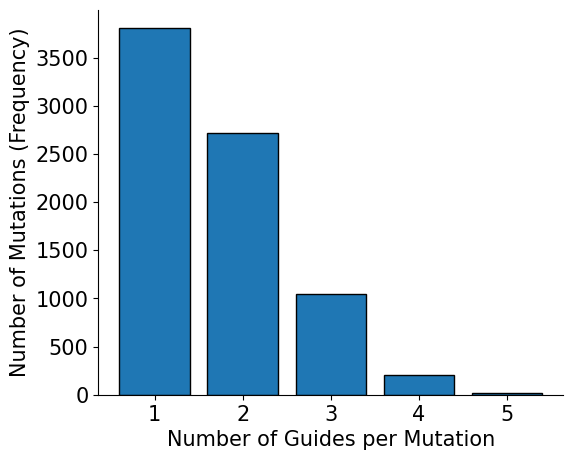

In [347]:
#also generate some graphs about what fraction we can target, etc.

u, c= np.unique([int(i) for i in targeting['mutation_idx']], return_counts=True)
u2, c2 = np.unique(c, return_counts=True)

fig, ax = plt.subplots(figsize=(6,5))
ax.bar(u2, c2, linewidth=1, edgecolor='black')
ax.set_xlabel('Number of Guides per Mutation', fontsize=15)
ax.set_ylabel('Number of Mutations (Frequency)', fontsize=15)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)


In [367]:
pool1 = final[final['Pool']=='F1-R1']
pool2 = final[final['Pool']=='F2-R2']

pool11 = pool1[pool1['classification']!='non-targeting control']
pool22 = pool2[pool2['classification']!='non-targeting control']

print(f'Pool F1-R1: {np.unique(pool1["Editor"])}')
print(f'Pool F1-R1 REF alleles: {np.unique(pool11["Reference_Allele"])}')
print(f'Pool F1-R1 ALT alleles: {np.unique(pool11["Tumor_Seq_Allele2"])}')

print(f'Pool F2-R2: {np.unique(pool2["Editor"])}')
print(f'Pool F2-R2 REF alleles: {np.unique(pool22["Reference_Allele"])}')
print(f'Pool F2-R2 ALT alleles: {np.unique(pool22["Tumor_Seq_Allele2"])}')

Pool F1-R1: ['ABE']
Pool F1-R1 REF alleles: ['A' 'T']
Pool F1-R1 ALT alleles: ['C' 'G']
Pool F2-R2: ['CBE']
Pool F2-R2 REF alleles: ['C' 'G']
Pool F2-R2 ALT alleles: ['A' 'T']


27.0


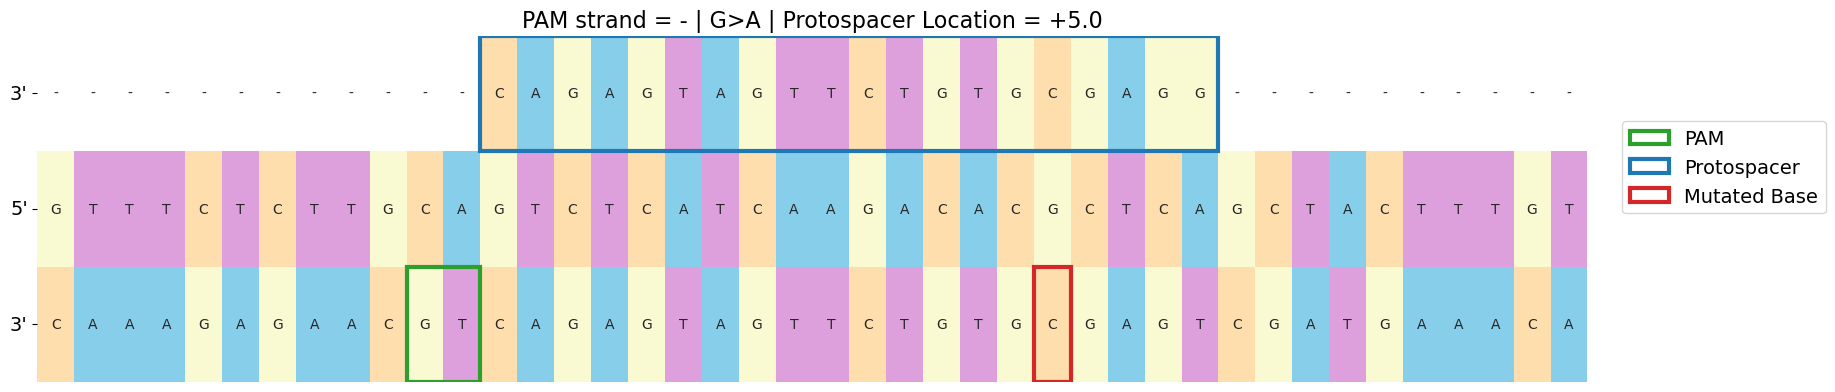

In [369]:
base.sensor_viz_base(final, 1000)

In [382]:

u, c = np.unique(pool1['classification'], return_counts=True)
u2, c2 = np.unique(pool2['classification'], return_counts=True)



[Text(4, 0, '+4'),
 Text(5, 0, '+5'),
 Text(6, 0, '+6'),
 Text(7, 0, '+7'),
 Text(8, 0, '+8')]

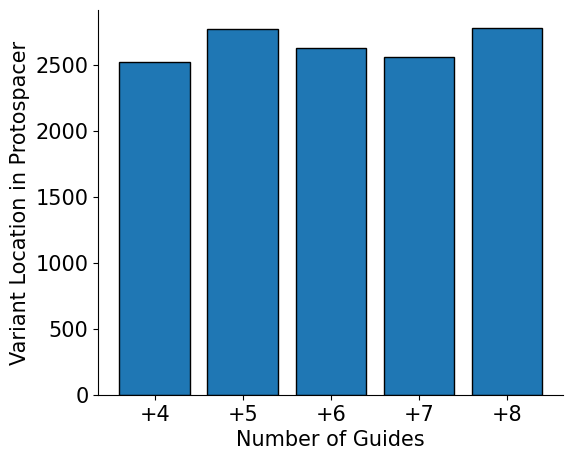

In [403]:
          

#also generate some graphs about what fraction we can target, etc.

u, c= np.unique(targeting['Protospacer_Location'], return_counts=True)

fig, ax = plt.subplots(figsize=(6,5))
ax.bar(u, c, linewidth=1, edgecolor='black')
ax.set_xlabel('Number of Guides', fontsize=15)
ax.set_ylabel('Variant Location in Protospacer', fontsize=15)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks([4,5,6,7,8])
ax.set_xticklabels( ['+4', '+5', '+6', '+7', '+8'])

In [390]:
input

,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,end_h,ref_seq_h,...,alt_seq_m,HGVSc_m,HGVSp_m,index,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Chromosome
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133730186,133730186,A,...,G,ENSMUST00000075759.13:c.29A>G,NaN,0,31668930,31668930,SNP,A,G,2
1,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133738349,133738349,G,...,A,ENSMUST00000075759.13:c.805G>A,G269E,1,31674718,31674718,SNP,G,A,2
2,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133748403,133748403,A,...,G,ENSMUST00000075759.13:c.1120A>G,E374G,2,31680830,31680830,SNP,A,G,2
3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133760819,133760819,G,...,A,ENSMUST00000075759.13:c.3177G>A,E1060K,3,31691660,31691660,SNP,G,A,2
4,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11,+,True,133759553,133759553,G,...,A,ENSMUST00000075759.13:c.1932G>A,G645S,4,31690415,31690415,SNP,G,A,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72992964,72992964,C,...,A,ENSMUST00000220518.2:c.1080G>A,G361R,11125,109519960,109519960,SNP,G,A,8
10944,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993335,72993335,C,...,A,ENSMUST00000220518.2:c.709G>A,R237Q,11126,109519589,109519589,SNP,G,A,8
10945,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72845844,72845844,G,...,T,ENSMUST00000220518.2:c.3652C>T,S1218L,11127,109660257,109660257,SNP,C,T,8
10946,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,9,-,True,72993336,72993336,G,...,T,ENSMUST00000220518.2:c.708C>T,R237delins*,11128,109519588,109519588,SNP,C,T,8


In [393]:
u, c= np.unique([int(i) for i in targeting['mutation_idx']], return_counts=True)
len(u)

7783

([<matplotlib.patches.Wedge at 0x7fad22b83580>,
 [Text(1.0672013826683042, 0.26661059399592507, ''),
  Text(-1.0672013826683042, -0.2666105939959249, '')])

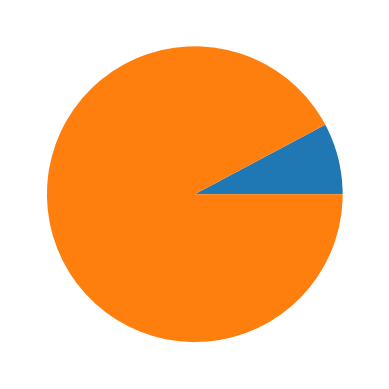

In [389]:
plt.pie([len(pool1), len(pool2)], radius=1)